<a href="https://colab.research.google.com/github/rizalrifai-ux/Vechicle_Classification_pytorch/blob/main/Vehicle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/


In [4]:
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
  ! kaggle datasets download iamsandeepprasad/vehicle-data-set

100% 4.72G/4.73G [01:22<00:00, 46.5MB/s]
100% 4.73G/4.73G [01:22<00:00, 61.5MB/s]


In [6]:
! unzip vehicle-data-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: cardataset/train/Motorcycle/000104_02.jpg  
  inflating: cardataset/train/Motorcycle/000104_14.jpg  
  inflating: cardataset/train/Motorcycle/000105_07.jpg  
  inflating: cardataset/train/Motorcycle/000105_08.jpg  
  inflating: cardataset/train/Motorcycle/000105_09.jpg  
  inflating: cardataset/train/Motorcycle/000106_18.jpg  
  inflating: cardataset/train/Motorcycle/000107_00.jpg  
  inflating: cardataset/train/Motorcycle/000107_03.jpg  
  inflating: cardataset/train/Motorcycle/000107_12.jpg  
  inflating: cardataset/train/Motorcycle/000107_15.jpg  
  inflating: cardataset/train/Motorcycle/000107_18.jpg  
  inflating: cardataset/train/Motorcycle/000108_02.jpg  
  inflating: cardataset/train/Motorcycle/000108_05.jpg  
  inflating: cardataset/train/Motorcycle/000109_08.jpg  
  inflating: cardataset/train/Motorcycle/000110_03.jpg  
  inflating: cardataset/train/Motorcycle/000110_05.jpg  
  inflating: cardataset/train/Motorcy

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
from google.colab import files
uploaded = files.upload()

Saving test.zip to test.zip


In [9]:
! unzip "test.zip"

Archive:  test.zip
   creating: test/
   creating: test/ambulance/
  inflating: test/ambulance/ambulance.jpg  
  inflating: test/ambulance/ambulance1.jpg  
   creating: test/barge/
  inflating: test/barge/barge.jpg    
  inflating: test/barge/barge1.jpg   
   creating: test/bicycle/
  inflating: test/bicycle/bicycle.jpg  
  inflating: test/bicycle/bicycle1.jpg  
   creating: test/boat/
  inflating: test/boat/boat.jpg      
  inflating: test/boat/boat1.jpg     
   creating: test/bus/
  inflating: test/bus/bus1.jpg       
  inflating: test/bus/bus_1.jpg      
   creating: test/car/
  inflating: test/car/car.jpg        
  inflating: test/car/car1.jpg       
   creating: test/cart/
  inflating: test/cart/cart.jpg      
  inflating: test/cart/cart1.jpg     
   creating: test/helicopter/
  inflating: test/helicopter/helicopter.jpg  
  inflating: test/helicopter/helicopter1.jpg  
   creating: test/limousine/
  inflating: test/limousine/limousine.jpg  
  inflating: test/limousine/limousine1.jp

In [ ]:
!mv "/content/drive/My Drive/*.jpg" "/content/train"


In [ ]:
# To verify that the previous command worked successfully
!ls /content/drive

'My Drive'


In [10]:
import numpy as np
import cv2


In [11]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [12]:
from torchsummary import summary

In [13]:
from PIL import Image

In [14]:
# The actual normalization values haven't been calculated
# Train has 1750 images for each car
# Valid has 500 images for each car
# Test varies per car 
# The following transforms are used for data augmentation
# The actual values for rgb channel normalization haven't been calculated, genereic values have been taken.

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [15]:
from google.colab import drive

#drive.mount('/content/gdrive' ,force_remount=True)
root_path = 'cardataset'  #change dir to your project folder

In [17]:
# Set train and valid directory paths

dataset = 'cardataset' 

train_directory = dataset+'/train'
valid_directory = dataset+'/valid'
test_directory = dataset+'/test'

# Batch size
bs = 32

# Number of classes
num_classes = 17
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=valid_directory, transform=image_transforms['test'])

}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

17
{0: 'Ambulance', 1: 'Barge', 2: 'Bicycle', 3: 'Boat', 4: 'Bus', 5: 'Car', 6: 'Cart', 7: 'Caterpillar', 8: 'Helicopter', 9: 'Limousine', 10: 'Motorcycle', 11: 'Segway', 12: 'Snowmobile', 13: 'Tank', 14: 'Taxi', 15: 'Truck', 16: 'Van'}


In [18]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
#to make it GPU compatible
resnet50 = resnet50.to('cuda:0') 

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [19]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [20]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 18 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cuda:0')

In [21]:
# Define Optimizer and Loss Function
# The Adam optimizer is being used 
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [22]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :para m model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size
         # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 10
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8379, Accuracy: 74.5186%, 
		Validation : Loss : 0.8917, Accuracy: 73.6376%, Time: 1119.8679s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.6691, Accuracy: 78.6321%, 
		Validation : Loss : 0.8003, Accuracy: 75.1974%, Time: 1118.1429s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.6367, Accuracy: 79.6254%, 
		Validation : Loss : 0.8215, Accuracy: 74.9663%, Time: 1091.6291s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.6193, Accuracy: 80.0280%, 
		Validation : Loss : 0.7186, Accuracy: 77.4697%, Time: 1096.3274s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.6027, Accuracy: 80.7457%, 
		Validation : Loss : 0.7804, Accuracy: 76.6609%, Time: 1112.1854s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.6005, Accuracy: 80.4393%, 
		Validation : Loss : 0.8194, Accuracy: 76.7957%, Time: 1089.7098s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.5775, Accuracy: 81.4239%, 
		Validation : Loss : 0.7468, Accuracy: 78.2207%, Time: 1097.2042s
Epoch: 8/10
Epoch : 007, Training: Loss: 

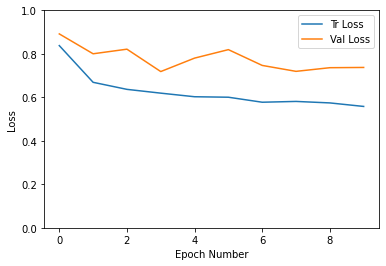

In [24]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

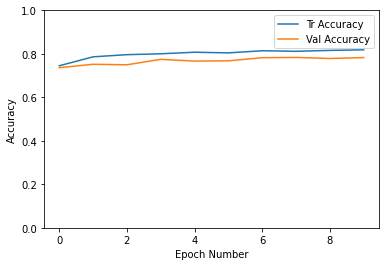

In [25]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [26]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [27]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : Ambulance , Score:  0.69797117
Predcition 2 : Van , Score:  0.2634049
Predcition 3 : Truck , Score:  0.03699368


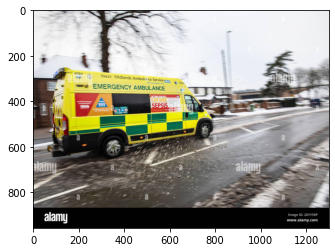

In [33]:
# Test a particular model on a test image

#dataset = 'caltech_10'
model = torch.load('cardataset_model_9.pt')
predict(model, 'cardataset/test/ambulance/ambulance1.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)

Predcition 1 : Van , Score:  0.503927
Predcition 2 : Ambulance , Score:  0.3612528
Predcition 3 : Car , Score:  0.07581182


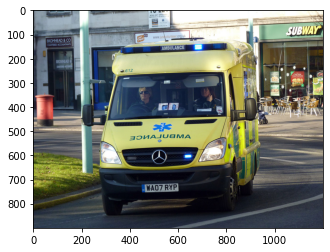

In [69]:
# Test a particular model on a test image

#dataset = 'caltech_10'
model1 = torch.load('cardataset_model_7.pt')
predict(model1, 'cardataset/test/ambulance/ambulance.jpg')

# Load Data from folders
#computeTestSetAccuracy(model, loss_func)

In [66]:
image_test = files.upload()

Saving taxi.jpg to taxi.jpg


In [64]:
#image_test.keys()

Predcition 1 : Taxi , Score:  0.89194524
Predcition 2 : Car , Score:  0.108019136
Predcition 3 : Truck , Score:  1.6045946e-05


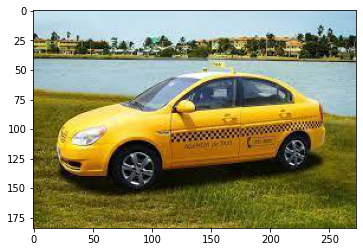

In [67]:
filename = next(iter(image_test))
predict(model,filename)
#cv2.imread(filename,cv2.IMREAD_COLOR)

Predcition 1 : Taxi , Score:  0.9689872
Predcition 2 : Car , Score:  0.030923894
Predcition 3 : Van , Score:  5.9022615e-05


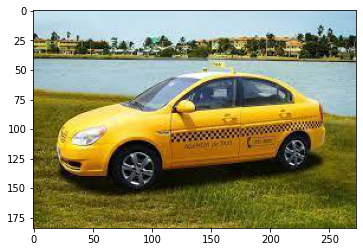

In [70]:
predict(model1,filename)

In [77]:
image_test = files.upload()

Saving bus1.jpg to bus1.jpg


Predcition 1 : Bus , Score:  0.9778653
Predcition 2 : Van , Score:  0.008353635
Predcition 3 : Boat , Score:  0.0067406273


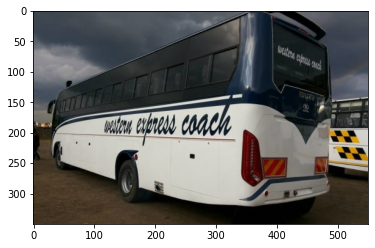

In [78]:
filename = next(iter(image_test))
predict(model,filename)

Predcition 1 : Bus , Score:  0.9778653
Predcition 2 : Van , Score:  0.008353635
Predcition 3 : Boat , Score:  0.0067406273


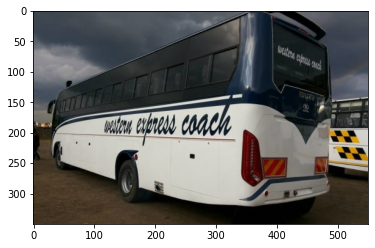

In [79]:
predict(model,'bus1.jpg')